In [2]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from lab7_cmd_types import CMD
import time
import numpy as np
LOG.propagate = False
import matplotlib.pyplot as plt


In [168]:
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

2025-03-24 00:30:13,627 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:81:04:26:a3:64
2025-03-24 00:30:17,026 | INFO     |: Connected to c0:81:04:26:a3:64


In [22]:
ble.disconnect()

2025-03-23 22:29:16,089 | INFO     |: Disconnected from A1C0DD95-B611-6CFA-AF80-6BCF50487F59


In [160]:
ble.send_command(CMD.PING, "")
s = ble.receive_string(ble.uuid['RX_STRING'])
print(s)

PONG


In [179]:
ble.send_command(CMD.START_STEP, "")

In [23]:
ble.send_command(CMD.STOP_STEP, "")

In [180]:
results = []


def notification_handler(uuid, byte_array):
    # Parse the data string from Arduino
    # Format: time | distance | velocity
    time_val, pwm, distance_val, velocity_val = ble.bytearray_to_string(
        byte_array).split('|')

    # Convert to appropriate types and store
    results.append([float(time_val), int(pwm), float(distance_val), float(velocity_val)])


# ble.stop_notify(ble.uuid['RX_STRING'])  # Optional: stop previous notifications
ble.start_notify(ble.uuid['RX_STRING'], notification_handler)
ble.send_command(CMD.COLLECT_DATA, "")

In [178]:
ble.stop_notify(ble.uuid['RX_STRING'])

In [28]:
import csv
import datetime

# Generate filename with timestamp to avoid overwriting
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"robot_data_{timestamp}.csv"

with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    # Write header
    csvwriter.writerow(['Time (ms)', 'Distance (mm)', 'Velocity (mm/s)'])
    # Write all data rows
    csvwriter.writerows(results)

print(f"Data saved to {filename}")

Data saved to robot_data_20250323_223015.csv


In [187]:
## Load results from csv file
import pandas as pd
df = pd.read_csv('robot_data_20250323_223015.csv')
results = df.values
print(results.shape)

## Fit the data

(55, 3)


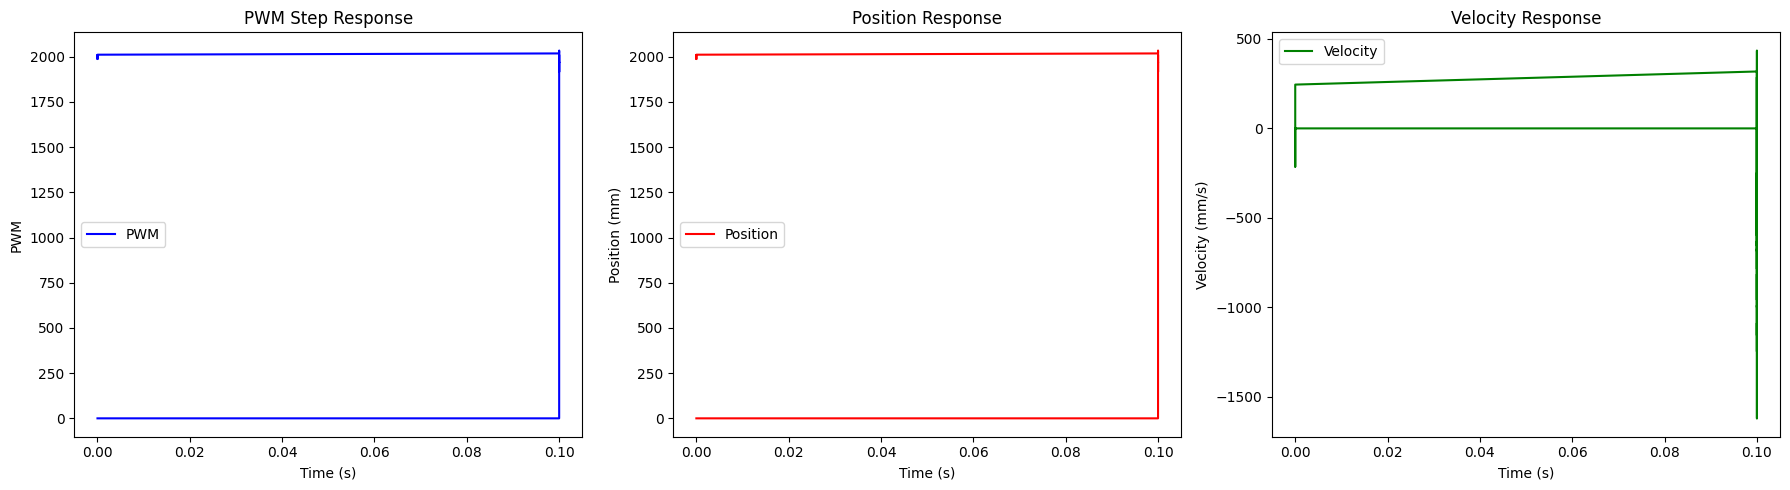

In [ ]:
# Now create the plots
# Convert results to numpy array for easier handling
data = np.array(results)
time_ms = data[:, 0]
distance = data[:, 1]
velocity = data[:, 2]

# Convert time to seconds
# Normalize to start at 0 and convert to seconds
time_s = (time_ms - time_ms[0]) / 1000.0

# Create figure with three subplots in a row
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# # Plot PWM vs Time
# ax1.plot(time_s, pwm, 'b-', label='PWM')
# ax1.set_ylabel('PWM')
# ax1.set_xlabel('Time (s)')
# ax1.set_title('PWM Step Response')
# ax1.legend()

# Plot Position (Distance) vs Time
ax2.plot(time_s, distance, 'r-', label='Position')
ax2.set_ylabel('Position (mm)')
ax2.set_xlabel('Time (s)')
ax2.set_title('Position Response')
ax2.legend()

# Plot Velocity vs Time
ax3.plot(time_s, velocity, 'g-', label='Velocity')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Velocity (mm/s)')
ax3.set_title('Velocity Response')
ax3.legend()

plt.tight_layout()
plt.show()

In [166]:
print(velocity)

[ 0.0000000e+00  2.0408000e+01  1.0309000e+01 -6.0869500e+02
  2.0000000e+02 -6.2500000e+01 -3.0303000e+01 -1.5306100e+02
  1.4432900e+02 -1.0000000e+01  2.0833000e+01  8.9108000e+01
  0.0000000e+00 -6.0606000e+01  0.0000000e+00 -1.0000000e+01
 -5.8823000e+01  7.3684000e+01  7.9207000e+01 -1.5151500e+02
  2.1276000e+01 -8.0000000e+01  7.1428000e+01  1.1111100e+02
 -8.2474000e+01  8.0000000e+01  2.9702000e+01 -1.9587600e+02
  2.0618500e+02 -2.0000000e+02  9.9000000e+00  5.1546000e+01
 -4.0816000e+01  1.6326500e+02 -2.1212100e+02  9.7087000e+01
 -8.1632000e+01  1.8750000e+02 -8.8235000e+01 -7.6086000e+01
  9.5238000e+01  2.1052000e+01 -2.0833000e+01  1.0204000e+01
 -9.0000000e+01  1.0576900e+02  1.2765900e+02 -1.3402000e+02
  6.0606000e+01  6.1224000e+01 -1.0000000e+02  1.5151500e+02
 -1.7346900e+02 -3.0927000e+01 -1.0101000e+01  5.7142800e+02
 -7.0000000e+01  2.9411000e+01  1.2765900e+02 -6.0606000e+01
 -8.0000000e+01  9.1836000e+01  3.0927000e+01 -2.0000000e+01
  0.0000000e+00  1.03090

Fitted equation: v(t) = -18.93 * (1 - e^(-28.45t))


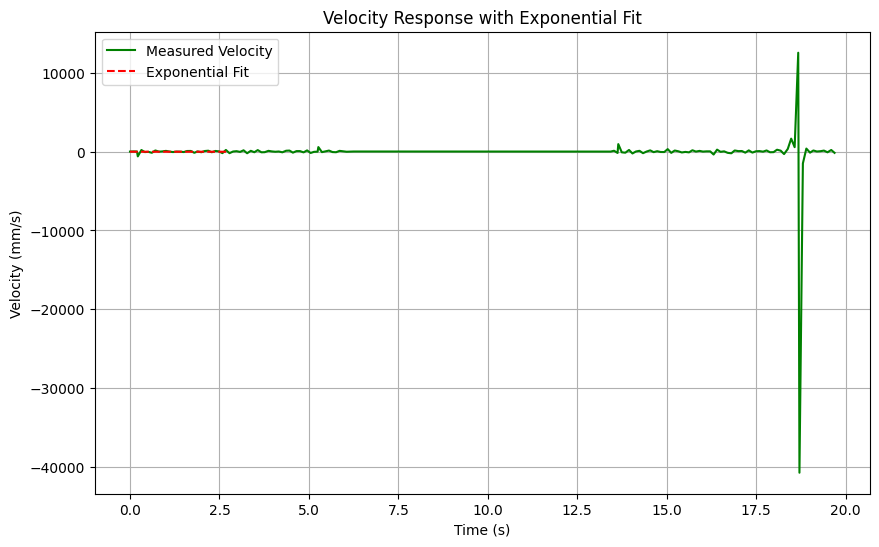

2025-03-24 00:29:57,316 | INFO     |: Disconnected from A1C0DD95-B611-6CFA-AF80-6BCF50487F59


In [167]:
from scipy.optimize import curve_fit
def exp_decay(x, A, b): 
    return A * (1 - np.exp(-b * x))

x_data = np.array(time_s[:30]) # cropped data
y_data = np.array(velocity[:30]) # cropped data

params, covariance = curve_fit(exp_decay, x_data, y_data, p0=(-1500, 3))
A_fit, b_fit = params

# Generate points for the fitted curve
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = exp_decay(x_fit, A_fit, b_fit)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_s, velocity, 'g-', label='Measured Velocity')
plt.plot(x_fit, y_fit, 'r--', label='Exponential Fit')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (mm/s)')
plt.title('Velocity Response with Exponential Fit')
plt.grid(True)
plt.legend()

# Print the fitted equation
print(f'Fitted equation: v(t) = {A_fit:.2f} * (1 - e^(-{b_fit:.2f}t))')

/var/folders/mp/jfdzp1rs3d551663_296s7xm0000gn/T/ipykernel_42289/3056742448.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(exp_decay_offset, x_data, y_data, p0=p0)


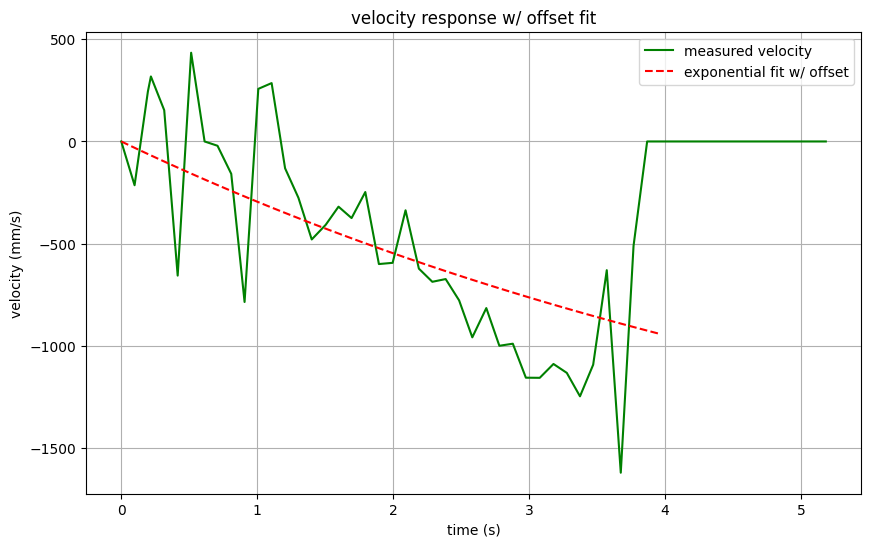

fitted eqn: v(t) = 0.00 + -2053.68 * (1 - e^(-0.15*t))


In [154]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def exp_decay_offset(x, a, b, c):
    return  a * (1 - np.exp(-b * x))


# assume time_s and velocity are numpy arrays
x_data = time_s[:42]
y_data = velocity[:42]

# initial guess
p0 = (-1800, 0.3, 0)

params, covariance = curve_fit(exp_decay_offset, x_data, y_data, p0=p0)
a_fit, b_fit, c_fit = params

# generate points for fitted curve
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = exp_decay_offset(x_fit, a_fit, b_fit, c_fit)

# plotting
plt.figure(figsize=(10, 6))
plt.plot(time_s, velocity, 'g-', label='measured velocity')
plt.plot(x_fit, y_fit, 'r--', label='exponential fit w/ offset')
plt.xlabel('time (s)')
plt.ylabel('velocity (mm/s)')
plt.title('velocity response w/ offset fit')
plt.legend()
plt.grid(True)
plt.show()

print(
    f'fitted eqn: v(t) = {c_fit:.2f} + {a_fit:.2f} * (1 - e^(-{b_fit:.2f}*t))')